The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


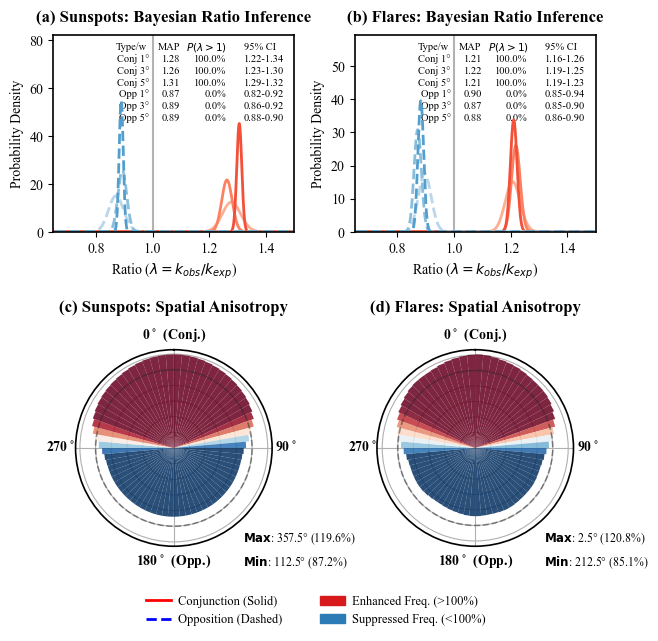

Plotting complete, saved to: ../../results/04_conj_enh_opp_sup/Fig06_Bayesian_Phase.eps
Data saved to: ../../results/04_conj_enh_opp_sup/Fig06_Bayesian_Phase_Source.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import scipy.ndimage as ndimage
import os

# =============================================================================
# 1. Path and Global Configuration
# =============================================================================
BASE_DIR = '../../results/04_conj_enh_opp_sup/'
FILES = {
    'SG_CSV': os.path.join(BASE_DIR, 'sg/sg_algo1_total_pairs.csv'),
    'SF_CSV': os.path.join(BASE_DIR, 'sf/sf_algo1_total_pairs.csv'),
    'SG_DATA': os.path.join(BASE_DIR, 'sg/cache_data/ready_All.parquet'),
    'SF_DATA': os.path.join(BASE_DIR, 'sf/cache_data/ready_Flare_All.parquet')
}
PLANET_COLS = ['199_lon', '299_lon', '399_lon', '499_lon', '599_lon', '699_lon', '799_lon', '899_lon']
SAVE_DATA_PATH = os.path.join(BASE_DIR, 'Fig06_Bayesian_Phase_Source.xlsx') # Excel save path

def setup_style():
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.linewidth': 1.2,
    })

# =============================================================================
# 2. Statistical Logic and Phase Calculation
# =============================================================================
def get_inference_data(k_obs, k_exp, x_range):
    pdf = gamma.pdf(x_range, a=k_obs + 1, scale=1.0/k_exp)
    p_enh = 1 - gamma.cdf(1.0, a=k_obs + 1, scale=1.0/k_exp)
    map_val = k_obs / k_exp
    ci = gamma.interval(0.95, a=k_obs + 1, scale=1.0/k_exp)
    return pdf, p_enh, map_val, ci

def calculate_all_phases(df):
    ref_col = 'hme_lon' if 'hme_lon' in df.columns else 'hgc_lon'
    phases = (df[PLANET_COLS].values - df[ref_col].values[:, np.newaxis]) % 360.0
    return phases.flatten()

# =============================================================================
# 3. Main Plotting Program (with data saving function)
# =============================================================================
def plot_figure_6_final_v4():
    setup_style()
    fig = plt.figure(figsize=(7, 7)) 
    gs = GridSpec(2, 2, figure=fig, hspace=0.6, wspace=0.25, bottom=0.15)
    
    x_lambda = np.linspace(0.5, 1.6, 1000)
    c_colors = sns.color_palette("Reds", 6)[1:]
    o_colors = sns.color_palette("Blues", 6)[1:]
    
    types = [('Sunspots', 'SG_CSV', 'SG_DATA'), ('Flares', 'SF_CSV', 'SF_DATA')]

    # [New] List for collecting data
    inference_data_list = []
    spatial_data_list = []

    for i, (label, csv_key, data_key) in enumerate(types):
        # --- (A) Top: Bayesian Posterior Distribution ---
        ax_b = fig.add_subplot(gs[0, i])
        ax_b.grid(False)
        
        if os.path.exists(FILES[csv_key]):
            df_csv = pd.read_csv(FILES[csv_key])
            table_vals = []
            max_y = 0
            for t_idx, t_name in enumerate(['Conjunction', 'Opposition']):
                df_sub = df_csv[(df_csv['Group'] == 'Total') & (df_csv['Type'] == t_name)].sort_values('Window')
                colors = c_colors if t_name == 'Conjunction' else o_colors
                ls = '-' if t_name == 'Conjunction' else '--'
                
                for idx, w in enumerate([1, 3, 5]):
                    row = df_sub[df_sub['Window'] == w].iloc[0]
                    pdf, p_e, mv, ci = get_inference_data(row['k_obs'], row['k_exp'], x_lambda)
                    
                    # Plotting
                    ax_b.plot(x_lambda, pdf, color=colors[idx], lw=2, ls=ls, zorder=2)
                    max_y = max(max_y, np.max(pdf))
                    
                    # Prepare text for table display
                    tag = "Conj" if t_name == 'Conjunction' else "Opp"
                    table_vals.append([f"{tag} {w}°", f"{mv:.2f}", f"{p_e:.1%}", f"{ci[0]:.2f}-{ci[1]:.2f}"])

                    # [New] Collect Bayesian statistical data into list
                    inference_data_list.append({
                        'Dataset': label,          # Sunspots or Flares
                        'Type': t_name,            # Conjunction or Opposition
                        'Window_Deg': w,           # Window size
                        'k_obs': row['k_obs'],     # Observed value
                        'k_exp': row['k_exp'],     # Expected value
                        'Ratio_MAP': mv,           # MAP estimate
                        'Prob_Enhancement': p_e,   # Enhancement probability
                        'CI_Lower_95': ci[0],      # Confidence interval lower bound
                        'CI_Upper_95': ci[1]       # Confidence interval upper bound
                    })

            ax_b.axvline(1.0, color='black', ls='-', alpha=0.3, zorder=1)
            ax_b.set_title(f"({chr(97+i)}) {label}: Bayesian Ratio Inference", fontweight='bold', pad=10)
            ax_b.set_xlabel(r"Ratio ($\lambda = k_{obs} / k_{exp}$)")
            ax_b.set_ylabel("Probability Density")
            ax_b.set_xlim(0.65, 1.5)
            ax_b.set_ylim(0, max_y * 1.5) 
            
            # Table drawing
            col_widths = [0.23, 0.15, 0.24, 0.3]
            table = ax_b.table(cellText=table_vals, 
                               colLabels=['Type/w', 'MAP', r'$P(\lambda>1)$', '95% CI'],
                               colWidths=col_widths,
                               loc='upper right',             
                               bbox=[0.23, 0.55, 0.75, 0.42]) 
            table.auto_set_font_size(False); table.set_fontsize(7.5)
            for (r_idx, c_idx), cell in table.get_celld().items():
                cell.set_edgecolor('none')
                cell.set_alpha(0.7)
                if r_idx == 0: cell.visible_edges = 'BT'
                elif r_idx == len(table_vals): cell.visible_edges = 'B'

        # --- (B) Bottom: Polar Phase Plot ---
        ax_p = fig.add_subplot(gs[1, i], projection='polar')
        if os.path.exists(FILES[data_key]):
            df_raw = pd.read_parquet(FILES[data_key])
            phases = calculate_all_phases(df_raw)
            rads = np.deg2rad(phases[~np.isnan(phases)])
            counts, bins = np.histogram(rads, bins=72, range=(0, 2*np.pi))
            bin_centers = (bins[:-1] + bins[1:]) / 2
            norm_counts = (counts / np.mean(counts)) * 100
            
            smoothed = ndimage.gaussian_filter1d(norm_counts, sigma=1.5, mode='wrap')
            
            # Plotting
            mx_idx, mi_idx = np.argmax(smoothed), np.argmin(smoothed)
            max_deg, max_val = np.rad2deg(bin_centers[mx_idx]), smoothed[mx_idx]
            min_deg, min_val = np.rad2deg(bin_centers[mi_idx]), smoothed[mi_idx]
            
            cmap = plt.get_cmap('RdBu_r')
            ax_p.bar(bin_centers, smoothed, width=2*np.pi/72, 
                     color=[cmap(plt.Normalize(90, 110)(v)) for v in smoothed], alpha=0.85, zorder=2)
            
            # [New] Collect spatial distribution curve data
            # Create a temporary DataFrame to store data for the current plot
            df_spatial = pd.DataFrame({
                'Dataset': label,
                'Angle_Rad': bin_centers,
                'Angle_Deg': np.rad2deg(bin_centers),
                'Normalized_Freq': smoothed,
                'Raw_Counts': counts
            })
            spatial_data_list.append(df_spatial)
            
            info_text = (
                         f"$\\mathbf{{Max}}$: {max_deg:.1f}° ({max_val:.1f}%)\n"
                         f"$\\mathbf{{Min}}$: {min_deg:.1f}° ({min_val:.1f}%)")
            
            ax_p.text(0.85, -0.1, info_text, transform=ax_p.transAxes, 
                      bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'),
                      fontsize=8.5, linespacing=1.6)

            ax_p.set_theta_zero_location("N")
            ax_p.set_theta_direction(-1)
            ax_p.axhline(100, color='#333333', lw=1.2, ls='--', alpha=0.5, zorder=3)
            ax_p.set_xticks(np.deg2rad([0, 90, 180, 270]))
            ax_p.set_xticklabels([r'0$^\circ$ (Conj.)', r'90$^\circ$', r'180$^\circ$ (Opp.)', r'270$^\circ$'], fontweight='bold')
            ax_p.set_title(f"({chr(99+i)}) {label}: Spatial Anisotropy", fontweight='bold', pad=10)
            ax_p.set_yticklabels([])
            ax_p.tick_params(axis='x', pad=0)

    # --- (C) Combined Legend ---
    handles = [plt.Line2D([0], [0], color='red', lw=2, label='Conjunction (Solid)'),
               plt.Line2D([0], [0], color='blue', lw=2, ls='--', label='Opposition (Dashed)'),
               mpatches.Patch(color='#d7191c', label='Enhanced Freq. (>100%)'),
               mpatches.Patch(color='#2c7bb6', label='Suppressed Freq. (<100%)')]
    
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.02),
               fontsize=9, frameon=False, columnspacing=3.0, handletextpad=0.6)

    # --- (D) Save Image and Data ---
    save_path = os.path.join(BASE_DIR, 'Fig06_Bayesian_Phase.eps')
    plt.savefig(save_path, format='eps')
    plt.show()
    print(f"Plotting complete, saved to: {save_path}")

    # [Core Modification] Write collected data to Excel
    if inference_data_list and spatial_data_list:
        # 1. Organize Bayesian statistical data
        df_inference_all = pd.DataFrame(inference_data_list)
        
        # 2. Organize spatial curve data
        df_spatial_all = pd.concat(spatial_data_list, ignore_index=True)
        
        # 3. Write to Excel (using openpyxl engine)
        with pd.ExcelWriter(SAVE_DATA_PATH, engine='openpyxl') as writer:
            df_inference_all.to_excel(writer, sheet_name='Bayesian_Stats', index=False)
            df_spatial_all.to_excel(writer, sheet_name='Spatial_Curves', index=False)
        
        print(f"Data saved to: {SAVE_DATA_PATH}")
    
    plt.show()

if __name__ == '__main__':
    plot_figure_6_final_v4()